# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [1]:
#!g1.1
from celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os
from torch import nn

from torch import Tensor

In [2]:
#!g1.1
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

In [3]:
#!g1.1
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image

dataset = CelebaCustomDataset(
    transform=transform,
    root_dir='celeba/'
)

img = dataset[0]
img.shape

torch.Size([3, 64, 64])

### Визуализация датасета

In [4]:
#!g1.1
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

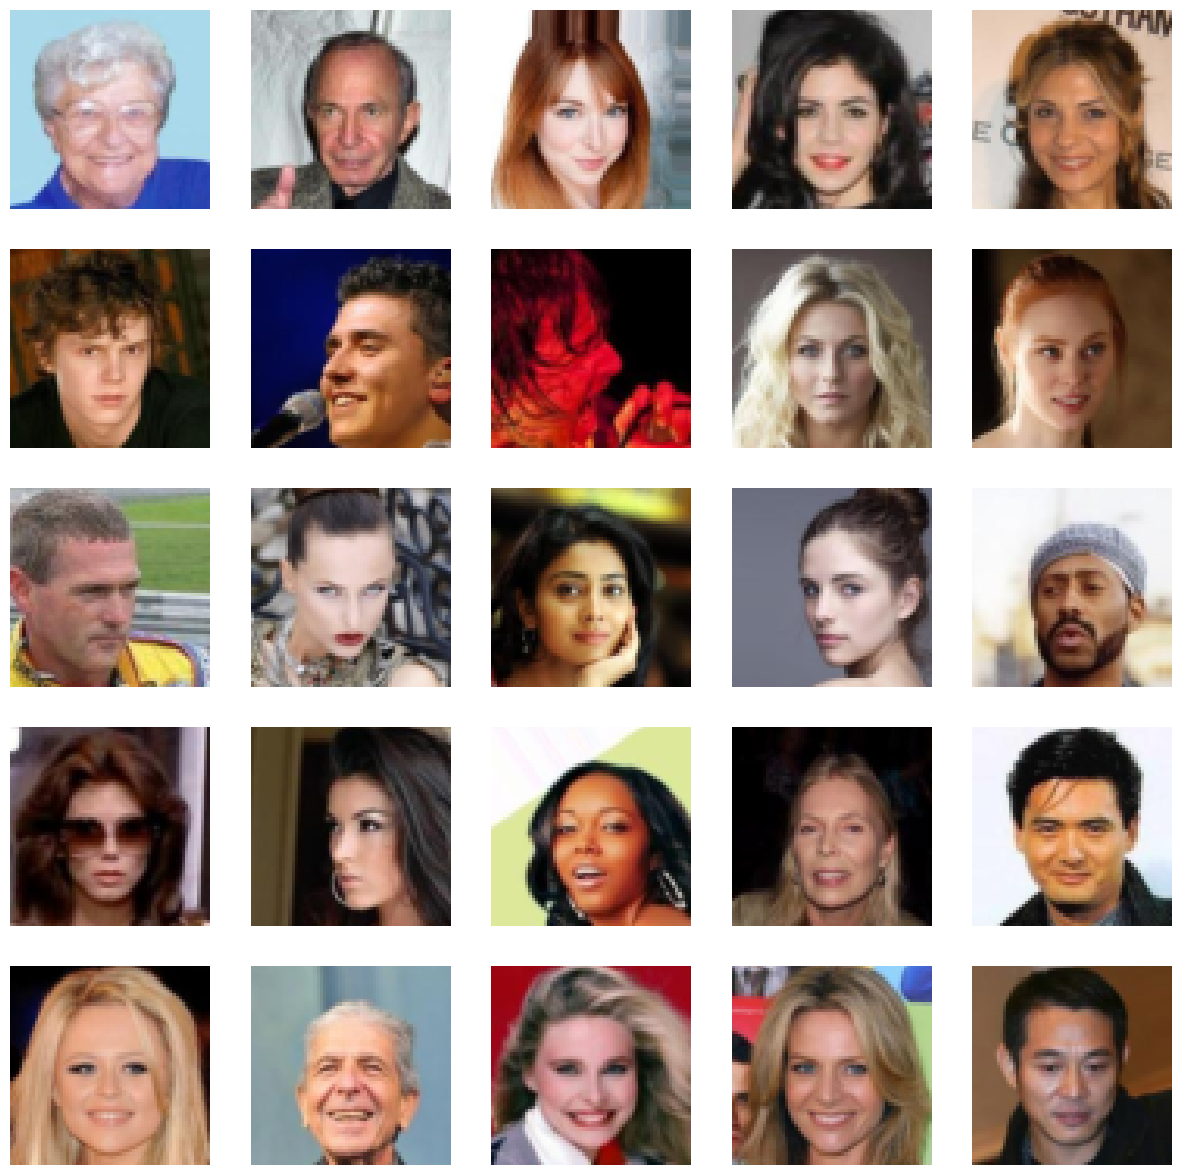

In [5]:
#!g1.1
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

In [ ]:
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow,
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
)
from nflib.spline_flows import NSF_AR, NSF_CL

# Neural splines, coupling
nfs_flow = NSF_CL if True else NSF_AR
flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
convs = [Invertible1x1Conv(dim=2) for _ in flows]
norms = [ActNorm(dim=2) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# construct the model
model = NormalizingFlowModel(prior, flows)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

from tqdm.auto import tqdm
n_epoches = 1000
model.train()
pbar = tqdm(range(n_epoches), desc='Loss: ?')
for k in pbar:
    for x in dataloader:
        x = x.to(device)
        zs, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss = -torch.sum(logprob) # NLL

        model.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description(f'Loss: {loss.item():.2f}')
        pbar.refresh()
pbar.close()

# No idea how to make it work

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA

Здесь нужно обучить VAE до нормального качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from scipy.linalg import sqrtm

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(z.size(0), 256, 4, 4)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss_fn(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

In [7]:
from torch.utils.data import DataLoader
batch_size=128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device('mps')

In [8]:
### To load pretrained
vae = torch.load("vae.pth", weights_only=False).to(device)

In [ ]:
from tqdm import tqdm

vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
epochs = 10

vae.train()
for epoch in range(epochs):
    tot_loss = 0
    for imgs in tqdm(dataloader):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae(imgs)
        loss, recon_loss, kl_loss = vae_loss_fn(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {tot_loss / len(dataloader.dataset):.6f}")

torch.save(vae, "vae.pth")

In [9]:
from torchvision.models import inception_v3, Inception_V3_Weights
import random

def calculate_fid(fake_images, real_images):
    inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=False).to(device)
    inception_model.eval()

    def get_features(imgs):
        with torch.no_grad():
            imgs = t_invnormalize(imgs).clamp(0, 1).to(device)
            imgs = torch.nn.functional.interpolate(
                imgs,
                size=(299, 299),
                mode='bilinear',
                align_corners=False
            )
            return inception_model(imgs).cpu().numpy()

    real_features = get_features(real_images)
    fake_features = get_features(fake_images)

    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)

In [10]:
import random
num_samples = 1000

real_images = torch.stack(
    [
        random.choice(dataset)
        for _ in range(num_samples)
    ],
    dim=0
)

vae.eval()
with torch.no_grad():
    z = torch.randn(num_samples, vae.latent_dim).to(device)
    fake_images = vae.decode(z).cpu()

fid = calculate_fid(fake_images, real_images)
print("FID VAE:", fid)

FID VAE: 395.10499799801846


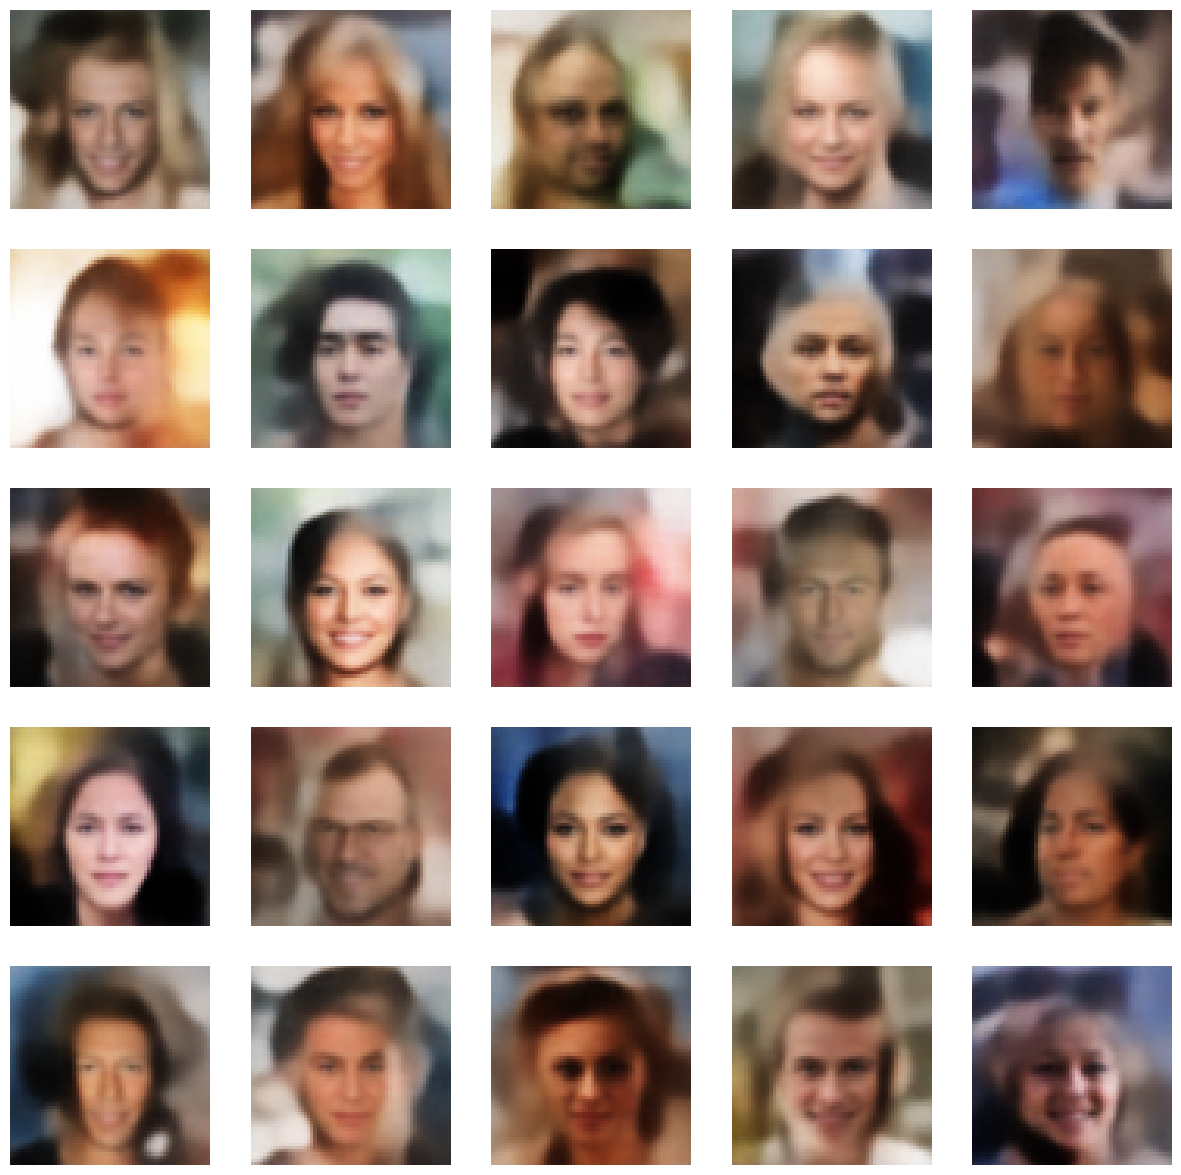

In [12]:
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(t_invnormalize(fake_images[i+25]).clamp(0, 1).cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [13]:
# 1. Энкодер: свёрточная сеть для получения μ и log(σ²)
class Encoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),   # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 32 -> 16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 16 -> 8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # 8 -> 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# 2. Декодер: сеть на основе ConvTranspose2d для генерации изображения из латентного кода
class Decoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), # 4 -> 8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 8 -> 16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 32 -> 64
            nn.Tanh(),  # поскольку изображения нормализованы в диапазоне [-1, 1]
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(z.size(0), 512, 4, 4)
        x_recon = self.deconv(h)
        return x_recon

# 3. Простой coupling layer для нормализующего потока (RealNVP-style)
class CouplingLayer(nn.Module):
    def __init__(self, dim):
        super(CouplingLayer, self).__init__()
        self.dim = dim
        # Разбиваем входной вектор на две части (предполагаем, что latent_dim четный)
        self.net = nn.Sequential(
            nn.Linear(dim // 2, 128),
            nn.ReLU(),
            nn.Linear(128, dim // 2 * 2)  # Выдаем и s (scale), и t (shift)
        )

    def forward(self, z, reverse=False):
        # Разбиваем на две части
        z1, z2 = z.chunk(2, dim=1)
        h = self.net(z1)
        s, t = h.chunk(2, dim=1)
        # Ограничим масштаб, например, tanh
        s = torch.tanh(s)
        if not reverse:
            z2 = z2 * torch.exp(s) + t
            log_det = s.sum(dim=1)
        else:
            z2 = (z2 - t) * torch.exp(-s)
            log_det = -s.sum(dim=1)
        z = torch.cat([z1, z2], dim=1)
        return z, log_det

# 4. Нормализующий поток как последовательность coupling layers
class Flow(nn.Module):
    def __init__(self, latent_dim, n_layers=4):
        super(Flow, self).__init__()
        self.layers = nn.ModuleList([CouplingLayer(latent_dim) for _ in range(n_layers)])

    def forward(self, z):
        log_det_total = 0
        for layer in self.layers:
            z, log_det = layer(z)
            log_det_total += log_det
        return z, log_det_total

# 5. Полная модель VAPNEV, объединяющая энкодер, поток и декодер
class VAPNEV(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAPNEV, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.flow = Flow(latent_dim)
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Получаем параметры латентного распределения
        mu, logvar = self.encoder(x)
        # Сэмплируем базовый латентный вектор
        z0 = self.reparameterize(mu, logvar)
        # Пропускаем через нормализующий поток
        z_flow, log_det = self.flow(z0)
        # Генерируем изображение
        x_recon = self.decoder(z_flow)
        return x_recon, mu, logvar, log_det

# --- Функция потерь ---
def vapnev_loss_fn(x, recon, mu, logvar, log_det):
    recon_loss = F.mse_loss(recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + kl_loss - log_det.sum()
    return total_loss

In [14]:
### To load pretrained
vapnev = torch.load("vapnev.pth", weights_only=False).to(device)

In [ ]:
from tqdm import tqdm

vapnev = VAPNEV().to(device)
optimizer = torch.optim.Adam(vapnev.parameters(), lr=0.001)
epochs = 10

vapnev.train()
for epoch in range(epochs):
    tot_loss = 0
    for imgs in tqdm(dataloader):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar, log_det = vapnev(imgs)
        loss = vapnev_loss_fn(imgs, recon, mu, logvar, log_det)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {tot_loss / len(dataloader.dataset):.6f}")

torch.save(vapnev, "vapnev.pth")

In [15]:
import random
num_samples = 1000

real_images = torch.stack(
    [
        random.choice(dataset)
        for _ in range(num_samples)
    ],
    dim=0
)

vapnev.eval()
with torch.no_grad():
    z_flow, _ = vapnev.flow(torch.randn(num_samples, vapnev.latent_dim).to(device))
    fake_images = vapnev.decoder(z_flow)

fid = calculate_fid(fake_images, real_images)
print("FID VAPNEV:", fid)

FID VAPNEV: 453.72480510186847


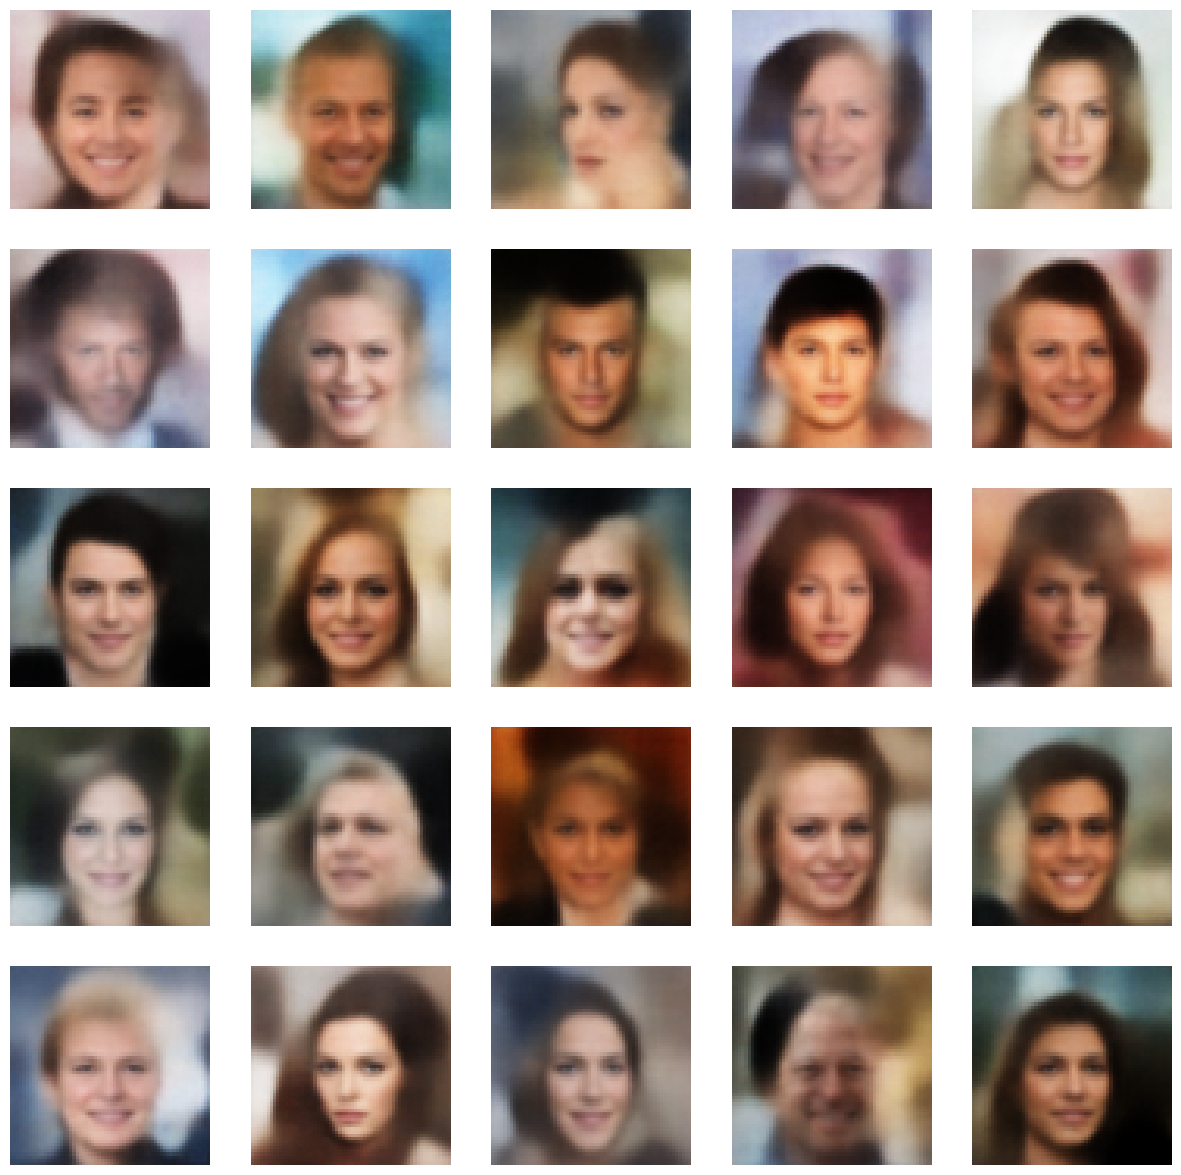

In [17]:
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(t_invnormalize(fake_images[i+25]).clamp(0, 1).cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [ ]:
# YOUR CODE HERE

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.